In [1]:
#!pip install -r requirements.txt

# Spark Cognition Data Science challenge

**Name**: Altiéris M. Peixoto

**Task:**
Design a model that will be able to predict whether a customer will respond to the
marketing campaign based on his/her information.  
In other words, predict the
**responded** target variable described above based on all the input variables
provided.

The data set includes customer information, described below, as a well as whether the customer responded to the	marketing campaign or not.  

- **custAge**: The age of the customer (in years)
- **profession**: Type of job
- **marital**: Marital status
- **schooling**: Education level
- **default**: Has a previous defaulted account?
- **housing**: Has a housing loan?
- **loan**: Has a personal loan?
- **contact**: Preferred contact type
- **month**: Last contact month
- **day_of_week**: Las contact day of the week
- **campaign**: NUmber of times the customer was contacted. 
- **pdays**: Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: Number of contacts performed before this campaign and for this client
- **poutcome**: Outcome of the previous marketing campaign
- **emp.var.rate**: Employment variation rate - quarterly indicator
- **cons.price.idx**: Consumer price index - monthly indicator
- **cons.conf.idx**: Consumer confidence index -monthly indicator
- **euribor3m**: Euribor 3 months rate - daily indicator
- **nr.employed**: Number of employees - quarterly indicator
- **pmonths**: Previous campaign (numeric; 999 means client was not previously contacted)
- **pastEmail**: Number of previous emails sent to this client
- **responded**: Did the customer respond to the marketing campaign and purchase policy?

## Import libs

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn import preprocessing
from numpy import quantile, where, random
from fancyimpute import KNN
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import chi2_contingency , randint as sp_randint, uniform as sp_uniform
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from scipy import stats

%matplotlib inline

## Helper functions

In [3]:
def apply_crosstab(feature,target):
    return round(pd.crosstab(feature,target, normalize = 'index') * 100, 2)

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 5))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    return plt
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def encoding_categories(df):
    df['schooling'] = df['schooling'].replace("illiterate", "unknown")
    df['schooling'] = df['schooling'].replace(np.nan, "unknown")
    df['schooling'] = df['schooling'].replace(["basic.4y","basic.6y","basic.9y","high.school","professional.course"], "high.school")
    
    df['default'] = df['default'].replace("yes", "unknown")
    
    df['marital'] = df['marital'].replace("unknown", "married")
    
    df['campaign_feedback_month'] = df['month'].replace(["sep","oct","mar","dec"], "good")
    df['campaign_feedback_month'] = df['month'].replace(["aug","jul","jun","may","nov"], "bad")
    df = df.drop("month", axis=1)
    
    df['loan'] = df['loan'].replace("unknown", "no")
    df['housing'] = df['housing'].replace("unknown", "no")

    df['profession'] = df['profession'].replace(["management","admin."], "admin.")
    df['profession'] = df['profession'].replace(["blue-collar","unknown","unemployed","housemaid","services","self-employed","entrepreneur","technician","student"], "self-employed")
    
    
    df['contact'] = df['contact'].map({'cellular': 1, "telephone": 0})
    
    return df

def count_plot(df, x, hue, fig_dims = (10, 5)):   
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.countplot(x=x, data=train_df, hue=hue, ax=ax)
    plt.show()    

## Exploratory Data Analysis

### Resume table

In [4]:
train_df = pd.read_csv("marketing_training.csv")

In [5]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,5,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


In [6]:
resumetable(train_df)

Dataset Shape: (7414, 22)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,custAge,float64,1804,72,55.000,NaN,42.000,5.29
1,profession,object,0,12,admin.,blue-collar,technician,2.97
2,marital,object,0,4,single,married,married,1.33
3,schooling,object,2155,8,university.degree,NaN,high.school,2.55
4,default,object,0,3,unknown,no,no,0.71
5,housing,object,0,3,no,no,no,1.13
6,loan,object,0,3,no,no,no,0.77
7,contact,object,0,2,cellular,cellular,telephone,0.94
8,month,object,0,10,nov,jul,may,2.65
9,day_of_week,object,711,5,mon,mon,mon,2.32


Here we can identify some columns with missing values
- custAge
- schooling
- day_of_week

There are categorical columns with high numer of categories:
- profession - 12 categories
- schooling  - 8 categories
- month - 10 categories

### TARGET

/work/tools/anaconda3/envs/spark-challenge/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


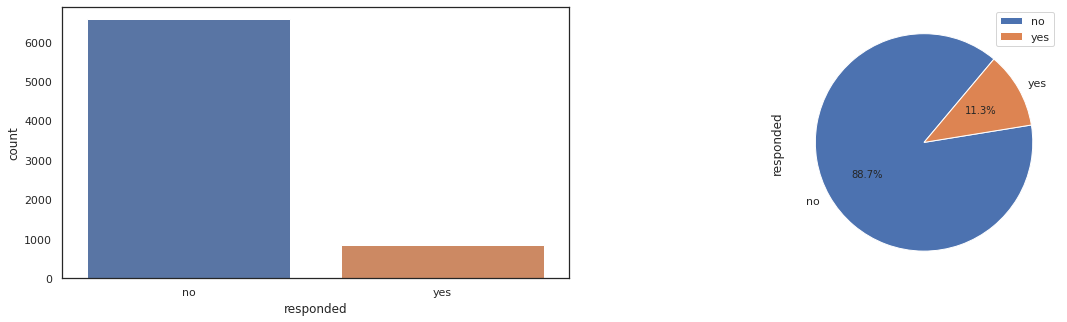

In [7]:
fig, axs = plt.subplots(1,2, figsize = (20,5))
plt1 = sns.countplot(train_df['responded'], ax = axs[0])
pie_churn = pd.DataFrame(train_df['responded'].value_counts())
pie_churn.plot.pie( subplots=True,labels = pie_churn.index.values, autopct='%1.1f%%', figsize = (15,5), startangle= 50, ax = axs[1])
plt.gca().set_aspect('equal')
plt.show()

In [8]:
responded = train_df['responded'].value_counts()/len(train_df) * 100

In [9]:
print(f"We can see that our dataset is high umbalanced. No: {round(responded['no'])}%, Yes: {round(responded['yes'])}%")

We can see that our dataset is high umbalanced. No: 89%, Yes: 11%


---

### CustAge : The age of the customer (in years)

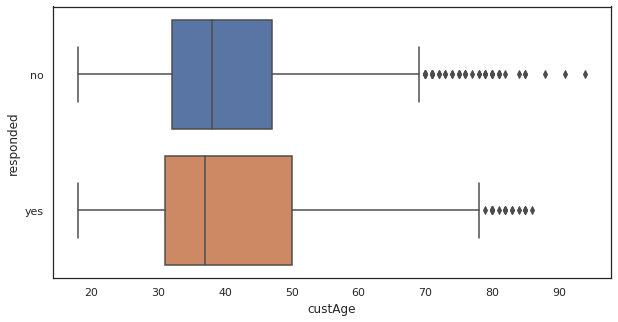

In [10]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.boxplot(x = 'custAge', y = 'responded', data = train_df)
plt.show()

In [11]:
train_df[train_df.responded == 'yes']['custAge'].describe()

count    622.000000
mean      41.234727
std       14.315725
min       18.000000
25%       31.000000
50%       37.000000
75%       50.000000
max       86.000000
Name: custAge, dtype: float64

In [12]:
train_df[train_df.responded == 'no']['custAge'].describe()

count    4988.000000
mean       39.857057
std        10.001956
min        18.000000
25%        32.000000
50%        38.000000
75%        47.000000
max        94.000000
Name: custAge, dtype: float64

Clients that reponded to a marketing campaign tends to be older by the mean.  
We will have to deal with some outiers as well.

### Profession: Type of job

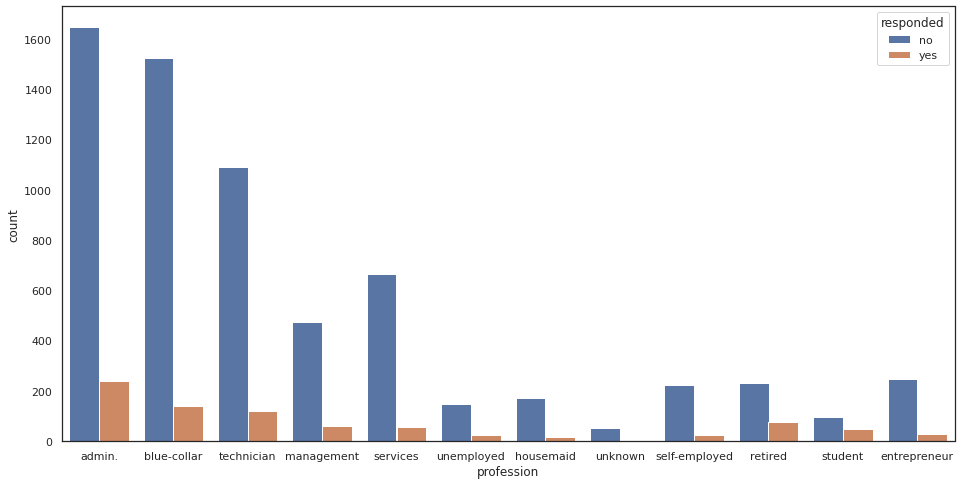

In [13]:
count_plot(train_df, "profession", "responded", fig_dims = (16, 8))

Maybe we could join this in less categories like.

- ["management","admin."] turns admin.
- ["blue-collar","unknown","unemployed","housemaid","services","self-employed","entrepreneur","technician","student"] turns "self-employed"

### Marital: Marital status

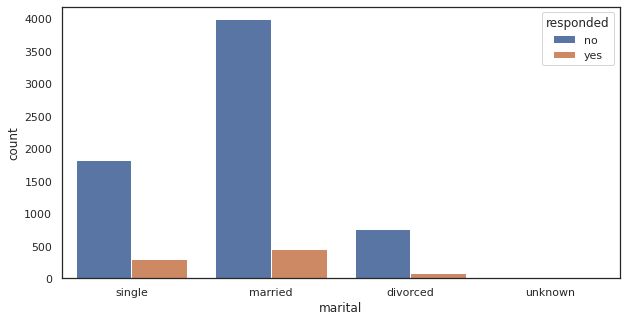

In [14]:
count_plot(train_df, "marital", "responded", fig_dims = (10, 5))

In [15]:
apply_crosstab(train_df['marital'],train_df['responded'])

responded,no,yes
marital,,
divorced,89.80,10.20
married,89.70,10.30
single,86.07,13.93
unknown,87.50,12.50


In [16]:
pd.crosstab(train_df['marital'],train_df['responded'])

responded,no,yes
marital,,
divorced,757,86
married,3987,458
single,1823,295
unknown,7,1


Most of clients are married.   
The unknown status has only 8 observations.  
Maybe we could join "unknown" status with "married".

### Schooling: Education level

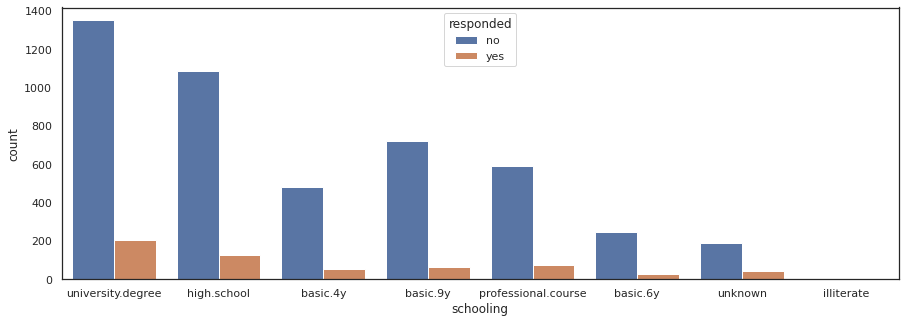

In [17]:
count_plot(train_df, "schooling", "responded", fig_dims = (15, 5))

In [18]:
apply_crosstab(train_df['schooling'],train_df['responded'])

responded,no,yes
schooling,,
basic.4y,90.07,9.93
basic.6y,90.55,9.45
basic.9y,91.84,8.16
high.school,89.39,10.61
illiterate,100.00,0.00
professional.course,89.16,10.84
university.degree,86.87,13.13
unknown,82.25,17.75


In [19]:
pd.crosstab(train_df['schooling'],train_df['responded'])

responded,no,yes
schooling,,
basic.4y,481,53
basic.6y,249,26
basic.9y,720,64
high.school,1087,129
illiterate,1,0
professional.course,592,72
university.degree,1350,204
unknown,190,41


Maybe we could join this in less categories like.

- ["basic.4y","basic.6y","basic.9y","high.school","professional.course"] turns high.school.

There are just one "illiterate" client.  
We can join "illiterate" category with "unknown" category.

### Default: Has a previous defaulted account?

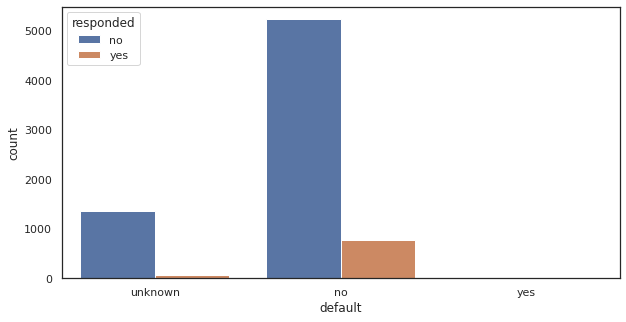

In [20]:
count_plot(train_df, "default", "responded", fig_dims = (10, 5))

In [21]:
apply_crosstab(train_df['default'],train_df['responded'])

responded,no,yes
default,,
no,87.23,12.77
unknown,94.69,5.31
yes,100.00,0.00


In [22]:
pd.crosstab(train_df['default'],train_df['responded'])

responded,no,yes
default,,
no,5217,764
unknown,1356,76
yes,1,0


There are just one "yes" default.  
We can join "yes" category with "unknown" category.

### Housing: Has a housing loan?

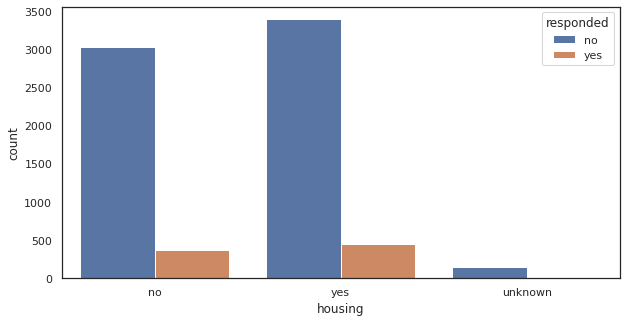

In [23]:
count_plot(train_df, "housing", "responded", fig_dims = (10, 5))

In [24]:
apply_crosstab(train_df['housing'],train_df['responded'])

responded,no,yes
housing,,
no,89.11,10.89
unknown,88.10,11.90
yes,88.31,11.69


In [25]:
pd.crosstab(train_df['housing'],train_df['responded'])

responded,no,yes
housing,,
no,3035,371
unknown,148,20
yes,3391,449


We can join "unknown" category with "no" category.

### Loan: Has a personal loan?

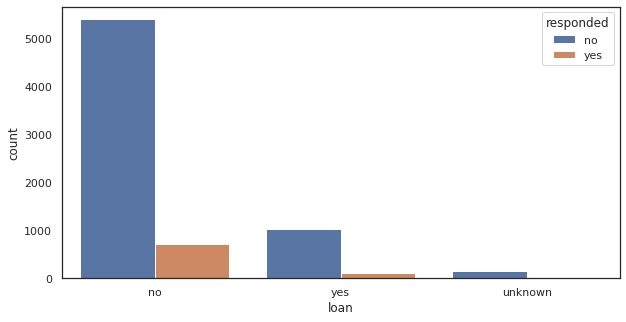

In [26]:
count_plot(train_df, "loan", "responded", fig_dims = (10, 5))

In [27]:
apply_crosstab(train_df['loan'],train_df['responded'])

responded,no,yes
loan,,
no,88.41,11.59
unknown,88.10,11.90
yes,90.15,9.85


In [28]:
pd.crosstab(train_df['loan'],train_df['responded'])

responded,no,yes
loan,,
no,5392,707
unknown,148,20
yes,1034,113


We can join "unknown" category with "no" category.

## Contact: Preferred contact type

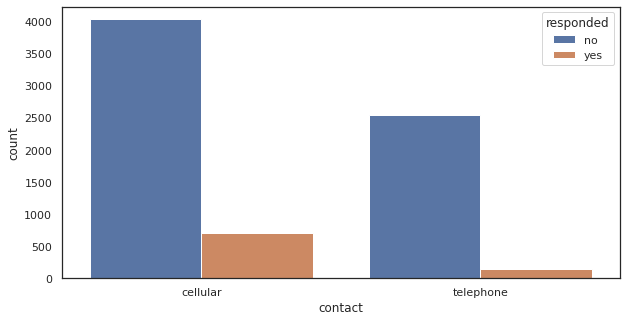

In [29]:
count_plot(train_df, "contact", "responded", fig_dims = (10, 5))

In [30]:
apply_crosstab(train_df['contact'],train_df['responded'])

responded,no,yes
contact,,
cellular,85.18,14.82
telephone,94.82,5.18


In [31]:
pd.crosstab(train_df['contact'],train_df['responded'])

responded,no,yes
contact,,
cellular,4030,701
telephone,2544,139


Customers tend to respond more positively if contacted via cell phone.   
We have just two contact categories. We can just binarize them. 

### Month: Last contact month

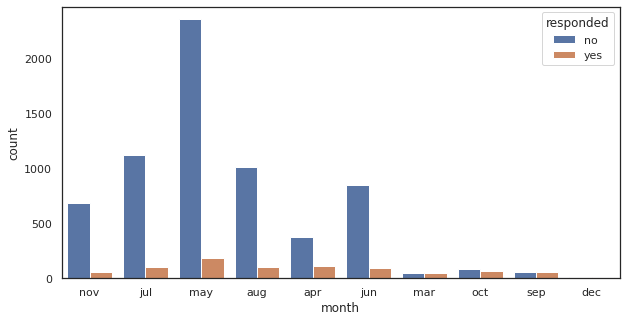

In [32]:
count_plot(train_df, "month", "responded", fig_dims = (10, 5))

In [33]:
apply_crosstab(train_df['month'],train_df['responded'])

responded,no,yes
month,,
apr,76.39,23.61
aug,90.74,9.26
dec,44.44,55.56
jul,91.38,8.62
jun,89.88,10.12
mar,51.61,48.39
may,92.88,7.12
nov,91.90,8.10
oct,56.55,43.45


In [34]:
pd.crosstab(train_df['month'],train_df['responded'])

responded,no,yes
month,,
apr,372,115
aug,1009,103
dec,12,15
jul,1123,106
jun,844,95
mar,48,45
may,2349,180
nov,681,60
oct,82,63


Seems that a campaign for some months were well accepted:
- Months when the last contact had a high response: ["apr", "sep","oct","mar","dec"]
- Months when the last contact had a lower response: ["aug","jul","jun","may","nov"]

### Day_of_week: Las contact day of the week

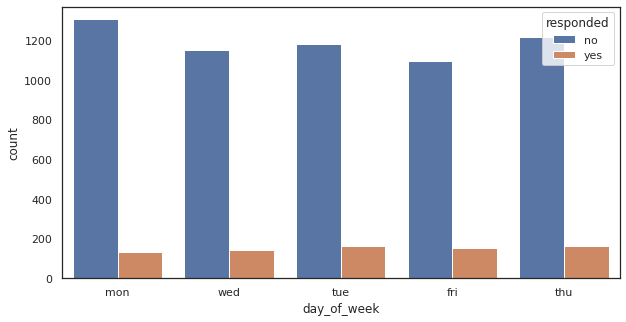

In [35]:
count_plot(train_df, "day_of_week", "responded", fig_dims = (10, 5))

In [36]:
apply_crosstab(train_df['day_of_week'],train_df['responded'])

responded,no,yes
day_of_week,,
fri,87.89,12.11
mon,90.63,9.37
thu,88.11,11.89
tue,87.99,12.01
wed,89.11,10.89


In [37]:
pd.crosstab(train_df['day_of_week'],train_df['responded'])

responded,no,yes
day_of_week,,
fri,1096,151
mon,1306,135
thu,1215,164
tue,1180,161
wed,1154,141


### Campaign: Number of times the customer was contacted.

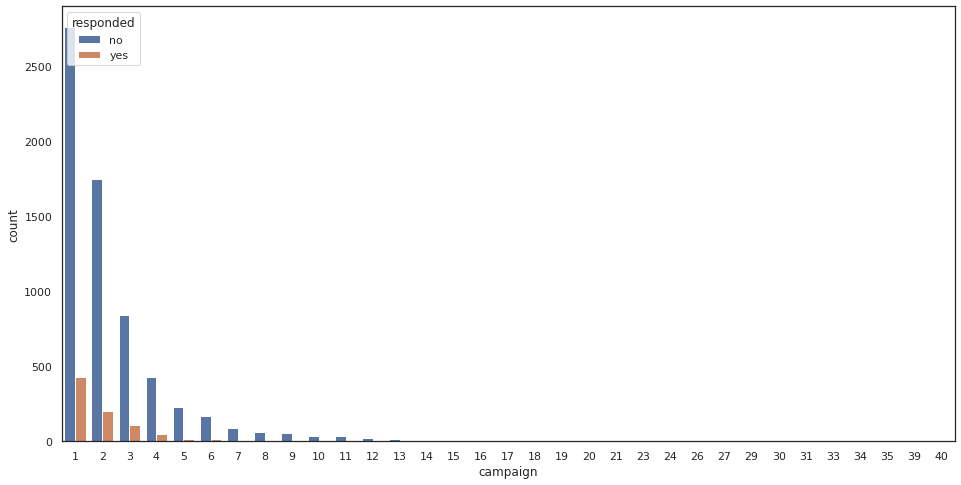

In [38]:
count_plot(train_df, "campaign", "responded", fig_dims = (16, 8))

In [39]:
pd.crosstab(train_df['campaign'],train_df['responded'])

responded,no,yes
campaign,,
1,2763,430
2,1753,200
3,844,112
4,430,47
5,230,15
6,166,13
7,90,10
8,64,2
9,58,3


It seems that after the 16 attempt to contact the customer does not respond anymore.

### Pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

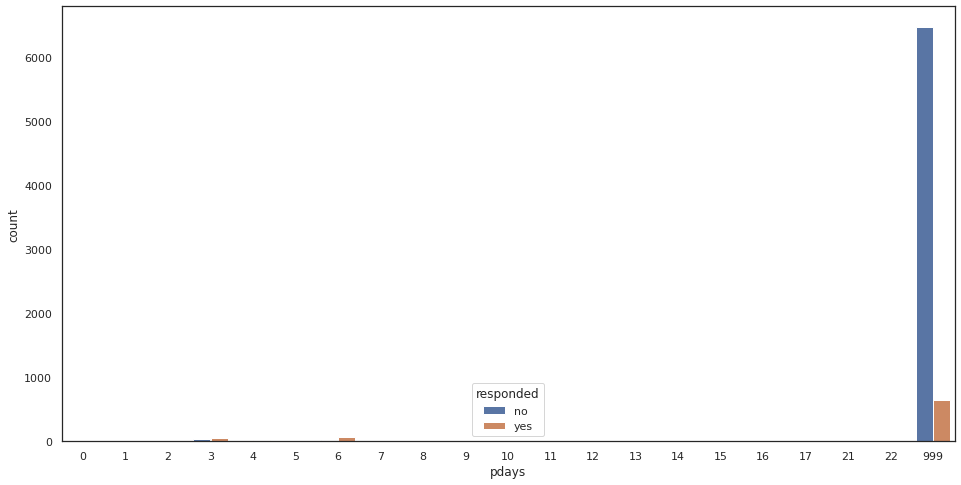

In [40]:
count_plot(train_df, "pdays", "responded", fig_dims = (16, 8))

In [41]:
pd.crosstab(train_df['pdays'],train_df['responded'])

responded,no,yes
pdays,,
0,1,1
1,3,0
2,4,9
3,35,47
4,7,15
5,2,5
6,21,64
7,7,8
8,2,1


Recent campaigns seem to have the greatest impact on the customer's positive response.  
As we can see most of the customers have not been contacted before.

### Previous: Number of contacts performed before this campaign and for this client

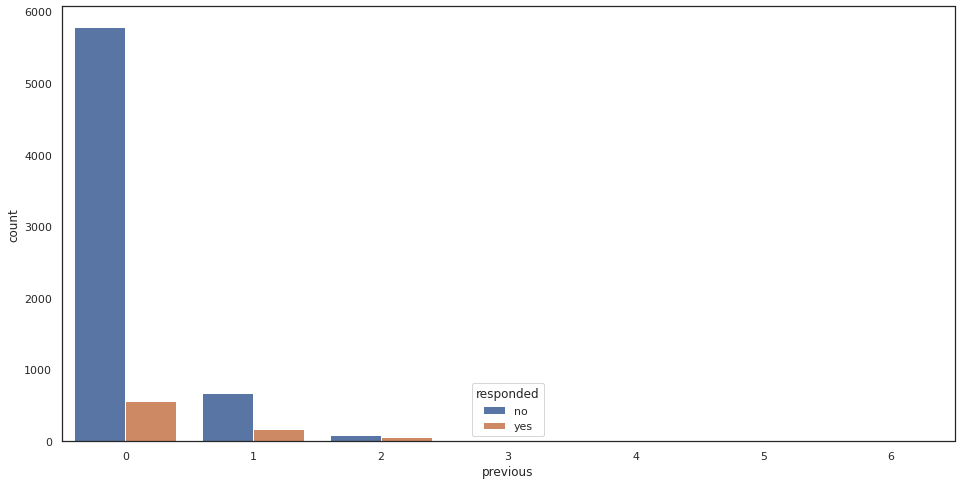

In [42]:
count_plot(train_df, "previous", "responded", fig_dims = (16, 8))

In [43]:
apply_crosstab(train_df['previous'],train_df['responded'])

responded,no,yes
previous,,
0,91.07,8.93
1,79.42,20.58
2,56.46,43.54
3,43.90,56.10
4,53.85,46.15
5,57.14,42.86
6,0.00,100.00


In [44]:
pd.crosstab(train_df['previous'],train_df['responded'])

responded,no,yes
previous,,
0,5783,567
1,679,176
2,83,64
3,18,23
4,7,6
5,4,3
6,0,1


Contacting the customer up to 3 times is more likely to have a positive response.

### Poutcome: Outcome of the previous marketing campaign

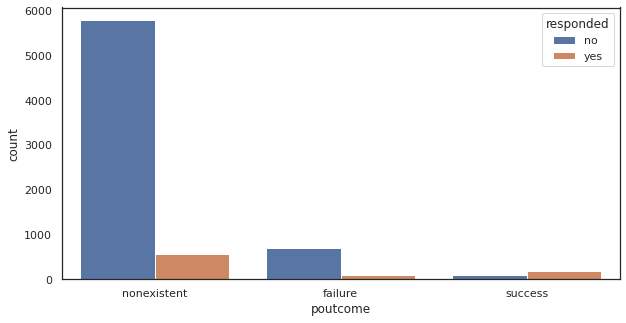

In [45]:
count_plot(train_df, "poutcome", "responded", fig_dims = (10, 5))

In [46]:
apply_crosstab(train_df['poutcome'],train_df['responded'])

responded,no,yes
poutcome,,
failure,87.75,12.25
nonexistent,91.07,8.93
success,33.71,66.29


In [47]:
pd.crosstab(train_df['poutcome'],train_df['responded'])

responded,no,yes
poutcome,,
failure,702,98
nonexistent,5783,567
success,89,175


### Emp.var.rate: Employment variation rate - quarterly indicator

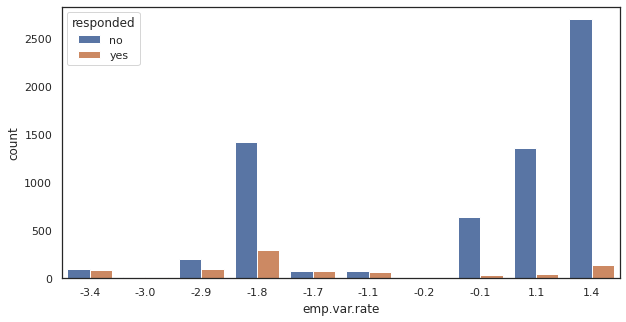

In [48]:
count_plot(train_df, "emp.var.rate", "responded", fig_dims = (10, 5))

In [49]:
apply_crosstab(train_df['emp.var.rate'],train_df['responded'])

responded,no,yes
emp.var.rate,,
-3.4,54.84,45.16
-3.0,42.31,57.69
-2.9,67.58,32.42
-1.8,82.71,17.29
-1.7,52.63,47.37
-1.1,55.80,44.20
-0.2,100.00,0.00
-0.1,94.66,5.34
1.1,96.85,3.15


In [50]:
pd.crosstab(train_df['emp.var.rate'],train_df['responded'])

responded,no,yes
emp.var.rate,,
-3.4,102,84
-3.0,11,15
-2.9,198,95
-1.8,1416,296
-1.7,80,72
-1.1,77,61
-0.2,1,0
-0.1,638,36
1.1,1353,44


### cons.price.idx: Consumer price index - monthly indicator

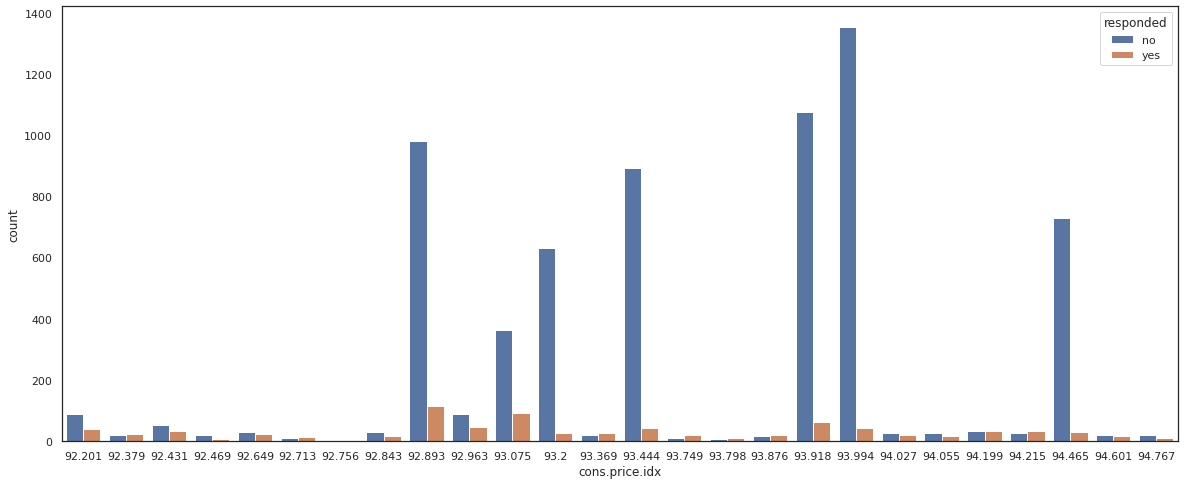

In [51]:
count_plot(train_df, "cons.price.idx", "responded", fig_dims = (20, 8))

In [52]:
pd.crosstab(train_df['cons.price.idx'],train_df['responded'])

responded,no,yes
cons.price.idx,,
92.201,90,40
92.379,20,25
92.431,53,35
92.469,20,8
92.649,29,24
92.713,11,15
92.756,1,0
92.843,29,18
92.893,980,116


### cons.conf.idx euribor3m: Consumer confidence index -monthly indicator

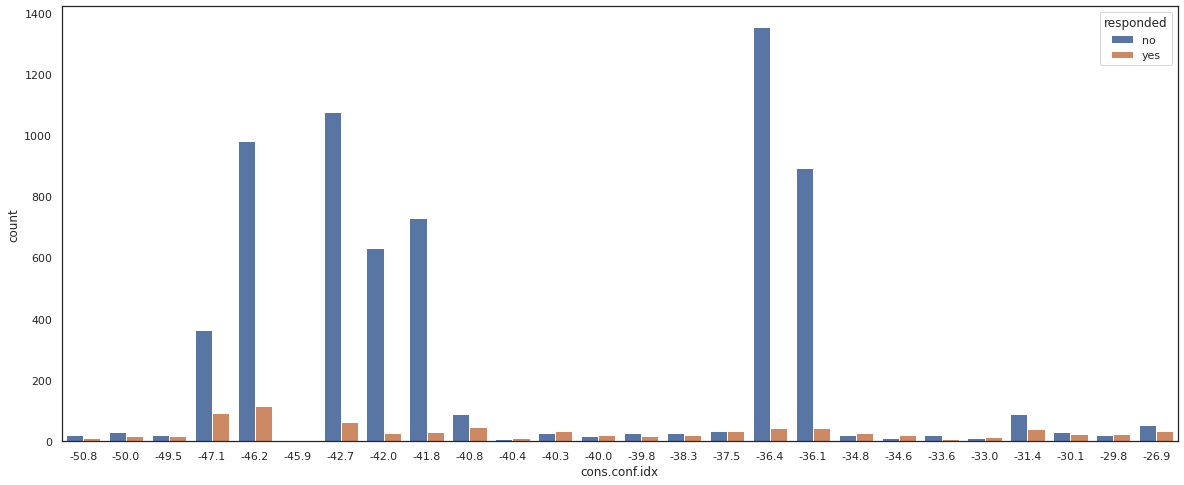

In [53]:
count_plot(train_df, "cons.conf.idx", "responded", fig_dims = (20, 8))

### euribor3m: Euribor 3 months rate - daily indicator

In [54]:
apply_crosstab(train_df['euribor3m'],train_df['responded'])

responded,no,yes
euribor3m,,
0.634,50.00,50.00
0.635,37.50,62.50
0.636,80.00,20.00
0.637,0.00,100.00
0.638,33.33,66.67
...,...,...
4.967,95.76,4.24
4.968,95.68,4.32
4.970,95.00,5.00


### nr.employed: NUmber of employees - quarterly indicator

In [55]:
apply_crosstab(train_df['nr.employed'],train_df['responded'])

responded,no,yes
nr.employed,,
4963.6,55.80,44.20
4991.6,52.63,47.37
5008.7,39.82,60.18
5017.5,54.84,45.16
5023.5,42.31,57.69
5076.2,67.58,32.42
5099.1,85.74,14.26
5176.3,100.00,0.00
5191.0,96.85,3.15


In [56]:
pd.crosstab(train_df['nr.employed'],train_df['responded'])

responded,no,yes
nr.employed,,
4963.6,77,61
4991.6,80,72
5008.7,45,68
5017.5,102,84
5023.5,11,15
5076.2,198,95
5099.1,1371,228
5176.3,1,0
5191.0,1353,44


Companies with fewer than 5,099 employees tend to respond more.

### pmonths: Previous campaign (numeric; 999 means client was not previously contacted)

In [57]:
pd.crosstab(train_df['pmonths'],train_df['responded'])

responded,no,yes
pmonths,,
0.000000,1,1
0.033333,3,0
0.066667,4,9
0.100000,35,47
0.133333,7,15
0.166667,2,5
0.200000,21,64
0.233333,7,8
0.266667,2,1


### pastEmail: Number of previous emails sent to this client

In [58]:
apply_crosstab(train_df['pastEmail'],train_df['responded'])

responded,no,yes
pastEmail,,
0,90.56,9.44
1,81.25,18.75
2,77.36,22.64
3,74.07,25.93
4,75.22,24.78
5,73.53,26.47
6,60.00,40.00
7,100.00,0.00
8,55.56,44.44


--- 

### FEATURE ENGINEERING

In [59]:
train_df = pd.read_csv("marketing_training.csv")

In [60]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,5,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


#### Encoding categorical features

In [61]:
train_df = encoding_categories(train_df)

In [62]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,campaign_feedback_month
0,55.0,admin.,single,university.degree,unknown,no,no,1,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no,bad
1,NaN,self-employed,married,unknown,no,no,no,1,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no,bad
2,42.0,self-employed,married,high.school,no,no,no,0,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no,bad
3,55.0,admin.,divorced,unknown,unknown,yes,yes,1,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no,bad
4,NaN,admin.,divorced,university.degree,no,yes,no,1,tue,5,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no,bad


In [63]:
train_df['responded'] = train_df['responded'].map({'yes': 1, "no": 0})

In [64]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,campaign_feedback_month
0,55.0,admin.,single,university.degree,unknown,no,no,1,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,0,bad
1,NaN,self-employed,married,unknown,no,no,no,1,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,0,bad
2,42.0,self-employed,married,high.school,no,no,no,0,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,0,bad
3,55.0,admin.,divorced,unknown,unknown,yes,yes,1,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,0,bad
4,NaN,admin.,divorced,university.degree,no,yes,no,1,tue,5,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,0,bad


In [65]:
for i in range(0, train_df.shape[1]):
    if(train_df.iloc[:,i].dtype=='object'):
        print(train_df.columns[i])
        labelencoder_X =  preprocessing.LabelEncoder()
        labelencoder_X.fit(train_df.iloc[:,i])
        train_df.iloc[:,i] = labelencoder_X.fit_transform(train_df.iloc[:,i])
        dump(labelencoder_X, f"encoders/{train_df.columns[i]}.joblib")
        
        train_df.iloc[:,i] = train_df.iloc[:,i].astype('object')
        train_df.iloc[:,i] = train_df.iloc[:,i].replace(-1, np.nan) 

profession
marital
schooling
default
housing
loan
day_of_week
poutcome
campaign_feedback_month


In [66]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,campaign_feedback_month
0,55.0,0,2,1,1,0,0,1,1,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,0,1
1,NaN,2,1,2,0,0,0,1,1,1,999,0,1,1.4,93.918,-42.7,4.960,5228.1,999.0,0,0,1
2,42.0,2,1,0,0,0,0,0,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,999.0,0,0,1
3,55.0,0,0,2,1,1,1,1,4,2,999,0,1,1.4,93.918,-42.7,4.962,5228.1,999.0,0,0,1
4,NaN,0,0,1,0,1,0,1,3,5,999,1,0,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,0,1


#### Imput missing values by K Nearest Neighbours

Here we are dealing with missing values using “Nearest Neighbor Imputation” .  
Other ways to filling missing values could be mean and median.

In [67]:
train_df=pd.DataFrame(KNN(k=5).fit_transform(train_df),columns=train_df.columns)

Imputing row 1/7414 with 0 missing, elapsed time: 9.829
Imputing row 101/7414 with 1 missing, elapsed time: 9.831
Imputing row 201/7414 with 0 missing, elapsed time: 9.833
Imputing row 301/7414 with 0 missing, elapsed time: 9.834
Imputing row 401/7414 with 0 missing, elapsed time: 9.836
Imputing row 501/7414 with 0 missing, elapsed time: 9.837
Imputing row 601/7414 with 0 missing, elapsed time: 9.839
Imputing row 701/7414 with 0 missing, elapsed time: 9.840
Imputing row 801/7414 with 1 missing, elapsed time: 9.842
Imputing row 901/7414 with 0 missing, elapsed time: 9.844
Imputing row 1001/7414 with 0 missing, elapsed time: 9.845
Imputing row 1101/7414 with 0 missing, elapsed time: 9.847
Imputing row 1201/7414 with 0 missing, elapsed time: 9.848
Imputing row 1301/7414 with 1 missing, elapsed time: 9.851
Imputing row 1401/7414 with 0 missing, elapsed time: 9.852
Imputing row 1501/7414 with 1 missing, elapsed time: 9.853
Imputing row 1601/7414 with 1 missing, elapsed time: 9.855
Imputing 

In [68]:
train_df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,campaign_feedback_month
0,55.000000,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,999.0,0.0,1.0,-0.1,93.200,-42.0,4.191,5195.8,999.0,0.0,0.0,1.0
1,40.999559,2.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,999.0,0.0,1.0,1.4,93.918,-42.7,4.960,5228.1,999.0,0.0,0.0,1.0
2,42.000000,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,999.0,0.0,0.0,1.0
3,55.000000,0.0,0.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,999.0,0.0,1.0,1.4,93.918,-42.7,4.962,5228.1,999.0,0.0,0.0,1.0
4,37.356540,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,5.0,999.0,1.0,0.0,-1.8,92.893,-46.2,1.291,5099.1,999.0,1.0,0.0,1.0


In [69]:
train_df.shape

(7414, 22)

#### Handling Outliers 

Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors.
It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. 
More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. 
By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors.
These are considered outliers.

In [70]:
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit_predict(train_df)

lofs_index = where(y_pred==-1) 

outlier_values = train_df.iloc[y_pred == -1]
train_df = train_df.drop(outlier_values.index)

In [71]:
train_df.shape

(7328, 22)

#### Separating target column from dataset

In [72]:
X_train = train_df.drop('responded',axis=1)
y = train_df['responded']

In [73]:
X_train.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,campaign_feedback_month
0,55.000000,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,999.0,0.0,1.0,-0.1,93.200,-42.0,4.191,5195.8,999.0,0.0,1.0
1,40.999559,2.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,999.0,0.0,1.0,1.4,93.918,-42.7,4.960,5228.1,999.0,0.0,1.0
2,42.000000,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,999.0,0.0,1.0,1.1,93.994,-36.4,4.857,5191.0,999.0,0.0,1.0
3,55.000000,0.0,0.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,999.0,0.0,1.0,1.4,93.918,-42.7,4.962,5228.1,999.0,0.0,1.0
4,37.356540,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,5.0,999.0,1.0,0.0,-1.8,92.893,-46.2,1.291,5099.1,999.0,1.0,1.0


#### Scaling features

Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as: `z = (x - u) / s`

where `u` is the mean of the training samples or zero if `with_mean=False`, and `s` is the standard deviation of the training samples or one if `with_std=False`.



In [74]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [75]:
X_scaled = scaler.transform(X_train)

### Separating Train/Test
We will use 70% of the data for training and reserve 30% for testing.

In [76]:
X = X_scaled
y = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)

---

### BASELINE MODEL

The first model is goig to be our baseline. I will use [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for that.

In [146]:
clf = RandomForestClassifier(random_state=0)

In [147]:
# fit the whole pipeline
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [148]:
predictions = clf.predict_proba(X_test) 

### MODEL EVAL - BASELINE

For this problem is interesting to maximize the [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) getting the threshold when both curves intercept.

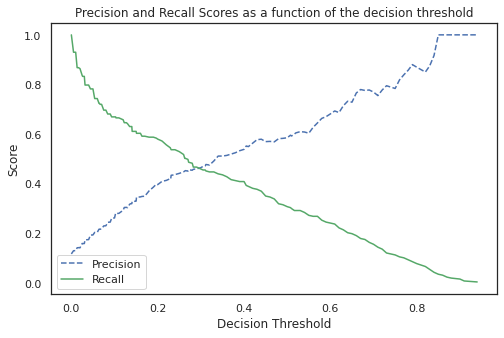

In [149]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predictions[:,1], pos_label=clf.classes_[1])
prv = plot_precision_recall_vs_threshold(precision, recall, thresholds)
prv.show()

In [150]:
y_pred = predictions[:,1] > 0.28

In [151]:
cm = metrics.confusion_matrix(y_test, y_pred )

In [152]:
target_names = ['no responded', 'responded']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

no responded       0.93      0.93      0.93      1942
   responded       0.46      0.47      0.46       257

    accuracy                           0.87      2199
   macro avg       0.69      0.70      0.70      2199
weighted avg       0.87      0.87      0.87      2199



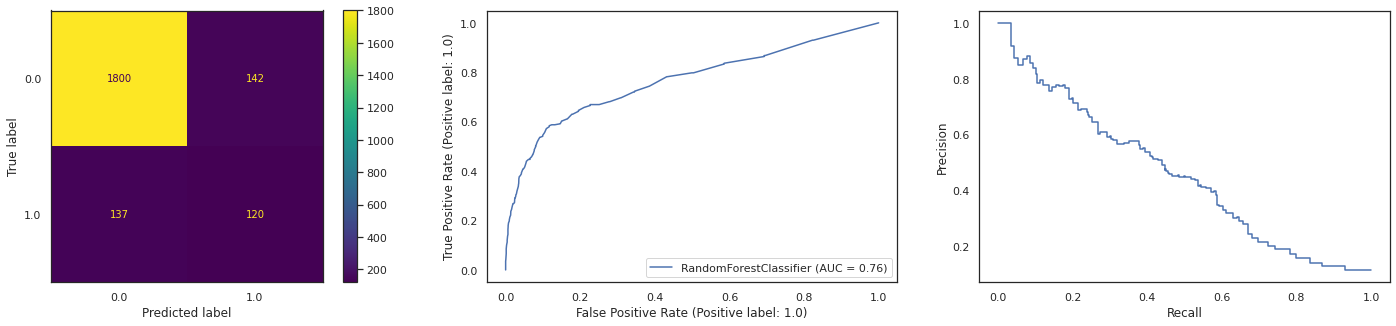

In [153]:
fig, axs = plt.subplots(1, 3, figsize = (25,5))
 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(ax = axs[0])
metrics.plot_roc_curve(clf, X_test, y_test , ax = axs[1])  

pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)


pr_display.plot(ax=axs[2])
plt.show()  

--- 

#### HIPERPARAMETERS TUNNING

Using Scikit-Learn’s [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [154]:
param_search = {
    'bootstrap': [True], # Whether bootstrap samples are used when building trees. 
                         # If False, the whole dataset is used to build each tree.
    'max_depth': [80, 90, 100, 110], # The maximum depth of the tree. 
    'max_features': ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split.
    'min_samples_leaf': [3, 4, 5],    # The minimum number of samples required to be at a leaf node.
    'min_samples_split': [8, 10, 12], # The minimum number of samples required to split an internal node.
    'n_estimators': [100, 200, 300,500, 1000], #The number of trees in the forest.
    
    'criterion': ['gini', 'entropy'] # The function to measure the quality of a split. 
                                     # Supported criteria are “gini” for the Gini impurity and “entropy” 
                                     # for the information gain. Note: this parameter is tree-specific.
}

rf_rss = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_search,
    n_iter=10,
    scoring='f1_micro',
    n_jobs=-1,
    cv=3,
    verbose=3,
    random_state=42
)

rf_rss.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000]},
                   random_state=42, scoring='f1_micro', verbose=3)

In [155]:
best_model = rf_rss.best_estimator_
predictions = best_model.predict_proba(X_test)

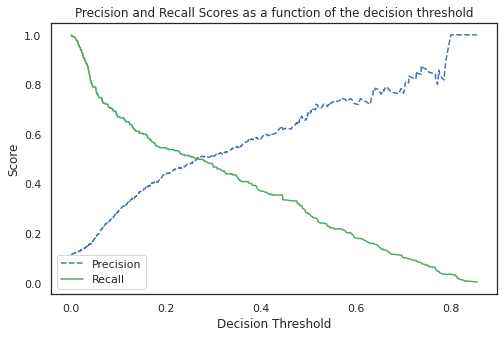

In [156]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predictions[:,1], pos_label=best_model.classes_[1])
prv = plot_precision_recall_vs_threshold(precision, recall, thresholds)
prv.show()

In [159]:
y_pred = predictions[:,1] > .26
target_names = ['no responded', 'responded']

cm = metrics.confusion_matrix(y_test, y_pred )

print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

no responded       0.93      0.93      0.93      1942
   responded       0.49      0.50      0.50       257

    accuracy                           0.88      2199
   macro avg       0.71      0.72      0.72      2199
weighted avg       0.88      0.88      0.88      2199



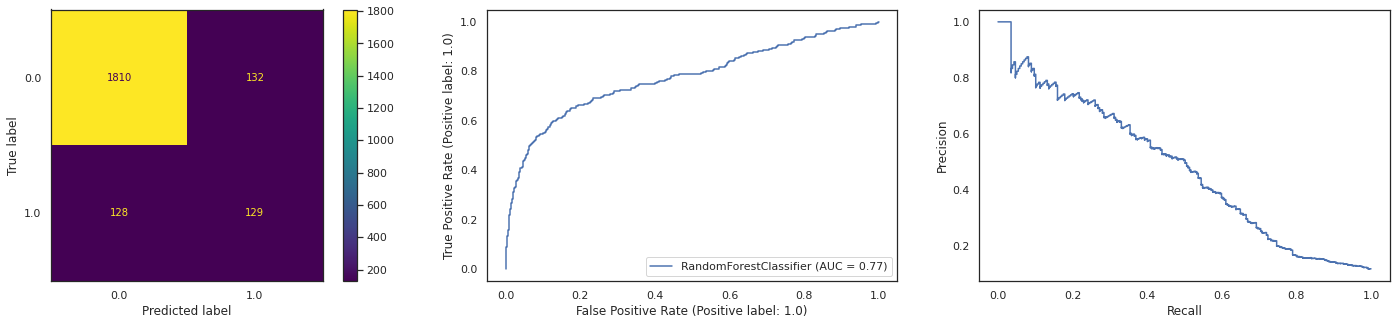

In [160]:
fig, axs = plt.subplots(1, 3, figsize = (25,5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax = axs[0])

metrics.plot_roc_curve(best_model, X_test, y_test , ax = axs[1])  

pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)

pr_display.plot(ax=axs[2])
plt.show()  

The Model had a significant improvement after the application of `RandomSearchCV` .<br/>
We will now run our model in the test suite and save the results.

--- 

## Test Dataset

In [161]:
df_test = pd.read_csv('marketing_test.csv')
df_test.head(5)

,Unnamed: 0,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail
0,0,NaN,entrepreneur,married,university.degree,no,yes,no,cellular,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,999.0,0
1,1,58.0,entrepreneur,married,university.degree,unknown,no,no,telephone,jun,fri,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0
2,2,48.0,entrepreneur,married,NaN,no,no,no,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0
3,3,35.0,blue-collar,married,NaN,no,yes,no,telephone,jun,tue,4,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,999.0,0
4,4,39.0,blue-collar,married,basic.6y,no,no,no,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0


In [162]:
df_test = encoding_categories(df_test)

In [163]:
cat_cols = ['profession', 'marital', 'schooling', 'default', 
            'housing', 'loan', 'day_of_week', 'poutcome',
            'campaign_feedback_month']

In [164]:
for col in cat_cols:
    labelencoder_X =  preprocessing.LabelEncoder()
    labelencoder_X = load(f"encoders/{col}.joblib")
    df_test[col] = labelencoder_X.transform(df_test[col])
    df_test[col] = df_test[col].astype('object')
    df_test[col] = df_test[col].replace(-1, np.nan) 

In [165]:
df_test.head()

,Unnamed: 0,custAge,profession,marital,schooling,default,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,campaign_feedback_month
0,0,NaN,2,1,1,0,1,0,1,4,2,999,0,1,1.4,93.918,-42.7,4.963,5228.1,999.0,0,1
1,1,58.0,2,1,1,1,0,0,0,0,1,999,0,1,1.4,94.465,-41.8,4.959,5228.1,999.0,0,1
2,2,48.0,2,1,2,0,0,0,1,1,1,999,0,1,1.4,93.918,-42.7,4.960,5228.1,999.0,0,1
3,3,35.0,2,1,2,0,1,0,0,3,4,999,0,1,1.4,94.465,-41.8,4.864,5228.1,999.0,0,1
4,4,39.0,2,1,0,0,0,0,1,1,1,999,0,1,1.4,93.918,-42.7,4.960,5228.1,999.0,0,1


In [166]:
df_test=pd.DataFrame(KNN(k=5).fit_transform(df_test),columns=df_test.columns)

Imputing row 1/824 with 1 missing, elapsed time: 0.116
Imputing row 101/824 with 0 missing, elapsed time: 0.117
Imputing row 201/824 with 1 missing, elapsed time: 0.117
Imputing row 301/824 with 0 missing, elapsed time: 0.118
Imputing row 401/824 with 0 missing, elapsed time: 0.119
Imputing row 501/824 with 0 missing, elapsed time: 0.120
Imputing row 601/824 with 0 missing, elapsed time: 0.121
Imputing row 701/824 with 0 missing, elapsed time: 0.121
Imputing row 801/824 with 0 missing, elapsed time: 0.122


In [167]:
scaler = preprocessing.StandardScaler().fit(df_test.drop('Unnamed: 0', axis=1))
X_scaled = scaler.transform(df_test.drop('Unnamed: 0', axis=1))

In [168]:
predictions = best_model.predict_proba(X_scaled)

In [169]:
df_test['responded'] = predictions[:,1] 

In [170]:
df_test['responded'] = df_test['responded'].apply(lambda x: 'yes' if x > .26 else 'no')

In [171]:
df_test = df_test.rename(columns={"Unnamed: 0": "id"})

### Save output

In [172]:
df_output = df_test[['id','responded']]

In [173]:
df_output.to_csv('output.csv', index=False)
df_output['responded'].value_counts()

no     712
yes    112
Name: responded, dtype: int64